In [1]:
import os
import os.path
import glob
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Pastel1'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "retina-dataset"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
#X = np.zeros((num_samples, width, height, channels))
cnt = 0
#list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        #list_paths.append(os.path.join(os.getcwd(),img_file))
        #img = image.load_img(img_file, target_size=(224, 224))
        #x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        #x = preprocess_input(x)
        #X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         Exudate	Number of images: 67600
Label: 1	Family:     Non_Exudate	Number of images: 70043
Processing images ...
Images processed: 137643


In [4]:
#X.shape

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'retina-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from retina-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(137643, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
#for index in skf.split(X, y):    
for index in skf.split(resnet50features, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [11]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='retina-topweights-max_val_acc-resnet50-Adam-2000epochs.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    predict = Dense(num_classes, activation='softmax', name='predictions')(top_input)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 110114 samples, validate on 27529 samples
Epoch 1/2000
110114/110114 [==============================] - 3s - loss: 0.8226 - acc: 0.5140 - val_loss: 0.7081 - val_acc: 0.5573
Epoch 2/2000
110114/110114 [==============================] - 2s - loss: 0.7078 - acc: 0.5556 - val_loss: 0.6627 - val_acc: 0.5801
Epoch 3/2000
110114/110114 [==============================] - 2s - loss: 0.6624 - acc: 0.5829 - val_loss: 0.6580 - val_acc: 0.5686
Epoch 4/2000
110114/110114 [==============================] - 2s - loss: 0.6577 - acc: 0.5714 - val_loss: 0.6547 - val_acc: 0.5544
Epoch 5/2000
110114/110114 [==============================] - 2s - loss: 0.6543 - acc: 0.5547 - val_loss: 0.6375 - val_acc: 0.5696
Epoch 6/2000
110114/110114 [==============================] - 2s - loss: 0.6371 - acc: 0.5690 - val_loss: 0.6103 - val_acc: 0.6280
Epoch 7/2000
110114/110114 [==============================] - 2s - loss: 0.6101 - acc: 0.6300 - val_loss: 0.5801 - val_acc: 0.7197
Epoch 8/2000
110114/110114 [====

110114/110114 [==============================] - 2s - loss: 0.3256 - acc: 0.8621 - val_loss: 0.3238 - val_acc: 0.8609
Epoch 124/2000
110114/110114 [==============================] - 2s - loss: 0.3249 - acc: 0.8625 - val_loss: 0.3231 - val_acc: 0.8614
Epoch 125/2000
110114/110114 [==============================] - 2s - loss: 0.3242 - acc: 0.8631 - val_loss: 0.3225 - val_acc: 0.8620
Epoch 126/2000
110114/110114 [==============================] - 2s - loss: 0.3235 - acc: 0.8636 - val_loss: 0.3218 - val_acc: 0.8625
Epoch 127/2000
110114/110114 [==============================] - 2s - loss: 0.3228 - acc: 0.8640 - val_loss: 0.3211 - val_acc: 0.8633
Epoch 128/2000
110114/110114 [==============================] - 2s - loss: 0.3221 - acc: 0.8644 - val_loss: 0.3204 - val_acc: 0.8636
Epoch 129/2000
110114/110114 [==============================] - 2s - loss: 0.3214 - acc: 0.8648 - val_loss: 0.3198 - val_acc: 0.8639
Epoch 130/2000
110114/110114 [==============================] - 2s - loss: 0.3208 - 

110114/110114 [==============================] - 1s - loss: 0.2679 - acc: 0.8934 - val_loss: 0.2672 - val_acc: 0.8934
Epoch 246/2000
110114/110114 [==============================] - 1s - loss: 0.2676 - acc: 0.8935 - val_loss: 0.2669 - val_acc: 0.8935
Epoch 247/2000
110114/110114 [==============================] - 1s - loss: 0.2673 - acc: 0.8936 - val_loss: 0.2666 - val_acc: 0.8937
Epoch 248/2000
110114/110114 [==============================] - 1s - loss: 0.2670 - acc: 0.8937 - val_loss: 0.2663 - val_acc: 0.8938
Epoch 249/2000
110114/110114 [==============================] - 1s - loss: 0.2666 - acc: 0.8938 - val_loss: 0.2659 - val_acc: 0.8939
Epoch 250/2000
110114/110114 [==============================] - 1s - loss: 0.2663 - acc: 0.8940 - val_loss: 0.2656 - val_acc: 0.8942
Epoch 251/2000
110114/110114 [==============================] - 1s - loss: 0.2660 - acc: 0.8942 - val_loss: 0.2653 - val_acc: 0.8942
Epoch 252/2000
110114/110114 [==============================] - 1s - loss: 0.2657 - 

110114/110114 [==============================] - 2s - loss: 0.2379 - acc: 0.9067 - val_loss: 0.2375 - val_acc: 0.9056
Epoch 368/2000
110114/110114 [==============================] - 2s - loss: 0.2377 - acc: 0.9068 - val_loss: 0.2373 - val_acc: 0.9056
Epoch 369/2000
110114/110114 [==============================] - 2s - loss: 0.2375 - acc: 0.9069 - val_loss: 0.2371 - val_acc: 0.9056
Epoch 370/2000
110114/110114 [==============================] - 2s - loss: 0.2373 - acc: 0.9069 - val_loss: 0.2369 - val_acc: 0.9057
Epoch 371/2000
110114/110114 [==============================] - 2s - loss: 0.2371 - acc: 0.9070 - val_loss: 0.2368 - val_acc: 0.9057
Epoch 372/2000
110114/110114 [==============================] - 2s - loss: 0.2369 - acc: 0.9071 - val_loss: 0.2366 - val_acc: 0.9057
Epoch 373/2000
110114/110114 [==============================] - 2s - loss: 0.2367 - acc: 0.9072 - val_loss: 0.2364 - val_acc: 0.9058
Epoch 374/2000
110114/110114 [==============================] - 2s - loss: 0.2365 - 

110114/110114 [==============================] - 1s - loss: 0.2185 - acc: 0.9147 - val_loss: 0.2183 - val_acc: 0.9134
Epoch 490/2000
110114/110114 [==============================] - 1s - loss: 0.2184 - acc: 0.9147 - val_loss: 0.2182 - val_acc: 0.9134
Epoch 491/2000
110114/110114 [==============================] - 1s - loss: 0.2182 - acc: 0.9148 - val_loss: 0.2181 - val_acc: 0.9135
Epoch 492/2000
110114/110114 [==============================] - 1s - loss: 0.2181 - acc: 0.9148 - val_loss: 0.2179 - val_acc: 0.9135
Epoch 493/2000
110114/110114 [==============================] - 1s - loss: 0.2180 - acc: 0.9149 - val_loss: 0.2178 - val_acc: 0.9136
Epoch 494/2000
110114/110114 [==============================] - 1s - loss: 0.2178 - acc: 0.9149 - val_loss: 0.2177 - val_acc: 0.9137
Epoch 495/2000
110114/110114 [==============================] - 1s - loss: 0.2177 - acc: 0.9149 - val_loss: 0.2175 - val_acc: 0.9137
Epoch 496/2000
110114/110114 [==============================] - 1s - loss: 0.2176 - 

110114/110114 [==============================] - 3s - loss: 0.2046 - acc: 0.9197 - val_loss: 0.2046 - val_acc: 0.9186
Epoch 612/2000
110114/110114 [==============================] - 3s - loss: 0.2045 - acc: 0.9197 - val_loss: 0.2045 - val_acc: 0.9186
Epoch 613/2000
110114/110114 [==============================] - 3s - loss: 0.2044 - acc: 0.9198 - val_loss: 0.2044 - val_acc: 0.9187
Epoch 614/2000
110114/110114 [==============================] - 2s - loss: 0.2043 - acc: 0.9198 - val_loss: 0.2043 - val_acc: 0.9188
Epoch 615/2000
110114/110114 [==============================] - 2s - loss: 0.2043 - acc: 0.9199 - val_loss: 0.2042 - val_acc: 0.9188
Epoch 616/2000
110114/110114 [==============================] - 2s - loss: 0.2042 - acc: 0.9199 - val_loss: 0.2041 - val_acc: 0.9189
Epoch 617/2000
110114/110114 [==============================] - 2s - loss: 0.2041 - acc: 0.9199 - val_loss: 0.2040 - val_acc: 0.9190
Epoch 618/2000
110114/110114 [==============================] - 2s - loss: 0.2040 - 

110114/110114 [==============================] - 1s - loss: 0.1941 - acc: 0.9239 - val_loss: 0.1941 - val_acc: 0.9231
Epoch 734/2000
110114/110114 [==============================] - 2s - loss: 0.1940 - acc: 0.9239 - val_loss: 0.1940 - val_acc: 0.9233
Epoch 735/2000
110114/110114 [==============================] - 1s - loss: 0.1939 - acc: 0.9239 - val_loss: 0.1940 - val_acc: 0.9233
Epoch 736/2000
110114/110114 [==============================] - 1s - loss: 0.1938 - acc: 0.9240 - val_loss: 0.1939 - val_acc: 0.9234
Epoch 737/2000
110114/110114 [==============================] - 1s - loss: 0.1938 - acc: 0.9240 - val_loss: 0.1938 - val_acc: 0.9234
Epoch 738/2000
110114/110114 [==============================] - 2s - loss: 0.1937 - acc: 0.9241 - val_loss: 0.1937 - val_acc: 0.9234
Epoch 739/2000
110114/110114 [==============================] - 2s - loss: 0.1936 - acc: 0.9241 - val_loss: 0.1937 - val_acc: 0.9234
Epoch 740/2000
110114/110114 [==============================] - 2s - loss: 0.1935 - 

110114/110114 [==============================] - 3s - loss: 0.1856 - acc: 0.9270 - val_loss: 0.1858 - val_acc: 0.9272
Epoch 856/2000
110114/110114 [==============================] - 3s - loss: 0.1856 - acc: 0.9270 - val_loss: 0.1858 - val_acc: 0.9272
Epoch 857/2000
110114/110114 [==============================] - 4s - loss: 0.1855 - acc: 0.9270 - val_loss: 0.1857 - val_acc: 0.9272
Epoch 858/2000
110114/110114 [==============================] - 3s - loss: 0.1854 - acc: 0.9271 - val_loss: 0.1857 - val_acc: 0.9273
Epoch 859/2000
110114/110114 [==============================] - 3s - loss: 0.1854 - acc: 0.9271 - val_loss: 0.1856 - val_acc: 0.9273
Epoch 860/2000
110114/110114 [==============================] - 3s - loss: 0.1853 - acc: 0.9272 - val_loss: 0.1855 - val_acc: 0.9274
Epoch 861/2000
110114/110114 [==============================] - 3s - loss: 0.1853 - acc: 0.9272 - val_loss: 0.1855 - val_acc: 0.9274
Epoch 862/2000
110114/110114 [==============================] - 3s - loss: 0.1852 - 

110114/110114 [==============================] - 1s - loss: 0.1787 - acc: 0.9299 - val_loss: 0.1791 - val_acc: 0.9304
Epoch 978/2000
110114/110114 [==============================] - 2s - loss: 0.1786 - acc: 0.9299 - val_loss: 0.1790 - val_acc: 0.9304
Epoch 979/2000
110114/110114 [==============================] - 1s - loss: 0.1786 - acc: 0.9300 - val_loss: 0.1790 - val_acc: 0.9304
Epoch 980/2000
110114/110114 [==============================] - 1s - loss: 0.1785 - acc: 0.9300 - val_loss: 0.1789 - val_acc: 0.9304
Epoch 981/2000
110114/110114 [==============================] - 1s - loss: 0.1785 - acc: 0.9300 - val_loss: 0.1789 - val_acc: 0.9304
Epoch 982/2000
110114/110114 [==============================] - 1s - loss: 0.1784 - acc: 0.9300 - val_loss: 0.1788 - val_acc: 0.9305
Epoch 983/2000
110114/110114 [==============================] - 1s - loss: 0.1784 - acc: 0.9300 - val_loss: 0.1788 - val_acc: 0.9305
Epoch 984/2000
110114/110114 [==============================] - 1s - loss: 0.1783 - 

110114/110114 [==============================] - 2s - loss: 0.1729 - acc: 0.9322 - val_loss: 0.1734 - val_acc: 0.9323
Epoch 1100/2000
110114/110114 [==============================] - 2s - loss: 0.1728 - acc: 0.9323 - val_loss: 0.1734 - val_acc: 0.9323
Epoch 1101/2000
110114/110114 [==============================] - 3s - loss: 0.1728 - acc: 0.9323 - val_loss: 0.1733 - val_acc: 0.9323
Epoch 1102/2000
110114/110114 [==============================] - 2s - loss: 0.1727 - acc: 0.9323 - val_loss: 0.1733 - val_acc: 0.9323
Epoch 1103/2000
110114/110114 [==============================] - 2s - loss: 0.1727 - acc: 0.9324 - val_loss: 0.1733 - val_acc: 0.9324
Epoch 1104/2000
110114/110114 [==============================] - 2s - loss: 0.1726 - acc: 0.9324 - val_loss: 0.1732 - val_acc: 0.9324
Epoch 1105/2000
110114/110114 [==============================] - 2s - loss: 0.1726 - acc: 0.9324 - val_loss: 0.1732 - val_acc: 0.9325
Epoch 1106/2000
110114/110114 [==============================] - 2s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1678 - acc: 0.9340 - val_loss: 0.1686 - val_acc: 0.9346
Epoch 1222/2000
110114/110114 [==============================] - 1s - loss: 0.1678 - acc: 0.9340 - val_loss: 0.1686 - val_acc: 0.9346
Epoch 1223/2000
110114/110114 [==============================] - 1s - loss: 0.1678 - acc: 0.9340 - val_loss: 0.1686 - val_acc: 0.9347
Epoch 1224/2000
110114/110114 [==============================] - 1s - loss: 0.1677 - acc: 0.9341 - val_loss: 0.1685 - val_acc: 0.9346
Epoch 1225/2000
110114/110114 [==============================] - 1s - loss: 0.1677 - acc: 0.9340 - val_loss: 0.1685 - val_acc: 0.9346
Epoch 1226/2000
110114/110114 [==============================] - 1s - loss: 0.1676 - acc: 0.9340 - val_loss: 0.1684 - val_acc: 0.9347
Epoch 1227/2000
110114/110114 [==============================] - 1s - loss: 0.1676 - acc: 0.9341 - val_loss: 0.1684 - val_acc: 0.9348
Epoch 1228/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1635 - acc: 0.9360 - val_loss: 0.1645 - val_acc: 0.9361
Epoch 1344/2000
110114/110114 [==============================] - 1s - loss: 0.1634 - acc: 0.9360 - val_loss: 0.1644 - val_acc: 0.9361
Epoch 1345/2000
110114/110114 [==============================] - 1s - loss: 0.1634 - acc: 0.9360 - val_loss: 0.1644 - val_acc: 0.9361
Epoch 1346/2000
110114/110114 [==============================] - 1s - loss: 0.1634 - acc: 0.9360 - val_loss: 0.1644 - val_acc: 0.9361
Epoch 1347/2000
110114/110114 [==============================] - 1s - loss: 0.1633 - acc: 0.9360 - val_loss: 0.1643 - val_acc: 0.9361
Epoch 1348/2000
110114/110114 [==============================] - 1s - loss: 0.1633 - acc: 0.9360 - val_loss: 0.1643 - val_acc: 0.9361
Epoch 1349/2000
110114/110114 [==============================] - 1s - loss: 0.1633 - acc: 0.9360 - val_loss: 0.1643 - val_acc: 0.9361
Epoch 1350/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1596 - acc: 0.9374 - val_loss: 0.1608 - val_acc: 0.9376
Epoch 1466/2000
110114/110114 [==============================] - 1s - loss: 0.1596 - acc: 0.9374 - val_loss: 0.1608 - val_acc: 0.9376
Epoch 1467/2000
110114/110114 [==============================] - 1s - loss: 0.1595 - acc: 0.9375 - val_loss: 0.1608 - val_acc: 0.9376
Epoch 1468/2000
110114/110114 [==============================] - 1s - loss: 0.1595 - acc: 0.9375 - val_loss: 0.1608 - val_acc: 0.9376
Epoch 1469/2000
110114/110114 [==============================] - 1s - loss: 0.1595 - acc: 0.9375 - val_loss: 0.1607 - val_acc: 0.9376
Epoch 1470/2000
110114/110114 [==============================] - 1s - loss: 0.1594 - acc: 0.9375 - val_loss: 0.1607 - val_acc: 0.9376
Epoch 1471/2000
110114/110114 [==============================] - 1s - loss: 0.1594 - acc: 0.9376 - val_loss: 0.1607 - val_acc: 0.9377
Epoch 1472/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1561 - acc: 0.9388 - val_loss: 0.1576 - val_acc: 0.9387
Epoch 1588/2000
110114/110114 [==============================] - 1s - loss: 0.1561 - acc: 0.9388 - val_loss: 0.1576 - val_acc: 0.9387
Epoch 1589/2000
110114/110114 [==============================] - 1s - loss: 0.1561 - acc: 0.9388 - val_loss: 0.1576 - val_acc: 0.9387
Epoch 1590/2000
110114/110114 [==============================] - 1s - loss: 0.1561 - acc: 0.9388 - val_loss: 0.1576 - val_acc: 0.9387
Epoch 1591/2000
110114/110114 [==============================] - 1s - loss: 0.1560 - acc: 0.9388 - val_loss: 0.1575 - val_acc: 0.9387
Epoch 1592/2000
110114/110114 [==============================] - 1s - loss: 0.1560 - acc: 0.9388 - val_loss: 0.1575 - val_acc: 0.9387
Epoch 1593/2000
110114/110114 [==============================] - 1s - loss: 0.1560 - acc: 0.9388 - val_loss: 0.1575 - val_acc: 0.9387
Epoch 1594/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9401 - val_loss: 0.1548 - val_acc: 0.9399
Epoch 1710/2000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9401 - val_loss: 0.1548 - val_acc: 0.9399
Epoch 1711/2000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9401 - val_loss: 0.1548 - val_acc: 0.9399
Epoch 1712/2000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9401 - val_loss: 0.1547 - val_acc: 0.9399
Epoch 1713/2000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9401 - val_loss: 0.1547 - val_acc: 0.9399
Epoch 1714/2000
110114/110114 [==============================] - 1s - loss: 0.1529 - acc: 0.9401 - val_loss: 0.1547 - val_acc: 0.9400
Epoch 1715/2000
110114/110114 [==============================] - 1s - loss: 0.1529 - acc: 0.9401 - val_loss: 0.1547 - val_acc: 0.9400
Epoch 1716/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9412 - val_loss: 0.1522 - val_acc: 0.9409
Epoch 1832/2000
110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9412 - val_loss: 0.1522 - val_acc: 0.9409
Epoch 1833/2000
110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9413 - val_loss: 0.1522 - val_acc: 0.9409
Epoch 1834/2000
110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9413 - val_loss: 0.1522 - val_acc: 0.9409
Epoch 1835/2000
110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9413 - val_loss: 0.1522 - val_acc: 0.9409
Epoch 1836/2000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9413 - val_loss: 0.1521 - val_acc: 0.9409
Epoch 1837/2000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9413 - val_loss: 0.1521 - val_acc: 0.9409
Epoch 1838/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1477 - acc: 0.9425 - val_loss: 0.1499 - val_acc: 0.9414
Epoch 1954/2000
110114/110114 [==============================] - 1s - loss: 0.1477 - acc: 0.9425 - val_loss: 0.1499 - val_acc: 0.9414
Epoch 1955/2000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9425 - val_loss: 0.1499 - val_acc: 0.9415
Epoch 1956/2000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9425 - val_loss: 0.1499 - val_acc: 0.9415
Epoch 1957/2000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9425 - val_loss: 0.1499 - val_acc: 0.9415
Epoch 1958/2000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9425 - val_loss: 0.1498 - val_acc: 0.9415
Epoch 1959/2000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9425 - val_loss: 0.1498 - val_acc: 0.9415
Epoch 1960/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.3788 - acc: 0.8229 - val_loss: 0.3762 - val_acc: 0.8250
Epoch 76/2000
110114/110114 [==============================] - 1s - loss: 0.3778 - acc: 0.8236 - val_loss: 0.3751 - val_acc: 0.8256
Epoch 77/2000
110114/110114 [==============================] - 1s - loss: 0.3767 - acc: 0.8242 - val_loss: 0.3741 - val_acc: 0.8258
Epoch 78/2000
110114/110114 [==============================] - 1s - loss: 0.3757 - acc: 0.8248 - val_loss: 0.3731 - val_acc: 0.8269
Epoch 79/2000
110114/110114 [==============================] - 1s - loss: 0.3746 - acc: 0.8257 - val_loss: 0.3720 - val_acc: 0.8279
Epoch 80/2000
110114/110114 [==============================] - 1s - loss: 0.3736 - acc: 0.8265 - val_loss: 0.3710 - val_acc: 0.8288
Epoch 81/2000
110114/110114 [==============================] - 1s - loss: 0.3725 - acc: 0.8273 - val_loss: 0.3700 - val_acc: 0.8295
Epoch 82/2000
110114/110114 [==============================] - 1s - loss: 0.3715 - acc: 0.

110114/110114 [==============================] - 1s - loss: 0.2952 - acc: 0.8785 - val_loss: 0.2934 - val_acc: 0.8812
Epoch 198/2000
110114/110114 [==============================] - 1s - loss: 0.2948 - acc: 0.8788 - val_loss: 0.2929 - val_acc: 0.8814
Epoch 199/2000
110114/110114 [==============================] - 1s - loss: 0.2944 - acc: 0.8789 - val_loss: 0.2925 - val_acc: 0.8816
Epoch 200/2000
110114/110114 [==============================] - 1s - loss: 0.2940 - acc: 0.8792 - val_loss: 0.2921 - val_acc: 0.8818
Epoch 201/2000
110114/110114 [==============================] - 1s - loss: 0.2935 - acc: 0.8794 - val_loss: 0.2917 - val_acc: 0.8821
Epoch 202/2000
110114/110114 [==============================] - 1s - loss: 0.2931 - acc: 0.8796 - val_loss: 0.2913 - val_acc: 0.8823
Epoch 203/2000
110114/110114 [==============================] - 1s - loss: 0.2927 - acc: 0.8798 - val_loss: 0.2908 - val_acc: 0.8826
Epoch 204/2000
110114/110114 [==============================] - 1s - loss: 0.2923 - 

110114/110114 [==============================] - 1s - loss: 0.2560 - acc: 0.8984 - val_loss: 0.2550 - val_acc: 0.8989
Epoch 320/2000
110114/110114 [==============================] - 1s - loss: 0.2558 - acc: 0.8985 - val_loss: 0.2548 - val_acc: 0.8989
Epoch 321/2000
110114/110114 [==============================] - 1s - loss: 0.2555 - acc: 0.8986 - val_loss: 0.2546 - val_acc: 0.8990
Epoch 322/2000
110114/110114 [==============================] - 1s - loss: 0.2553 - acc: 0.8987 - val_loss: 0.2543 - val_acc: 0.8991
Epoch 323/2000
110114/110114 [==============================] - 1s - loss: 0.2551 - acc: 0.8988 - val_loss: 0.2541 - val_acc: 0.8992
Epoch 324/2000
110114/110114 [==============================] - 1s - loss: 0.2548 - acc: 0.8989 - val_loss: 0.2539 - val_acc: 0.8993
Epoch 325/2000
110114/110114 [==============================] - 1s - loss: 0.2546 - acc: 0.8989 - val_loss: 0.2536 - val_acc: 0.8994
Epoch 326/2000
110114/110114 [==============================] - 1s - loss: 0.2544 - 

110114/110114 [==============================] - 1s - loss: 0.2321 - acc: 0.9082 - val_loss: 0.2320 - val_acc: 0.9095
Epoch 442/2000
110114/110114 [==============================] - 1s - loss: 0.2320 - acc: 0.9083 - val_loss: 0.2318 - val_acc: 0.9095
Epoch 443/2000
110114/110114 [==============================] - 1s - loss: 0.2318 - acc: 0.9083 - val_loss: 0.2317 - val_acc: 0.9094
Epoch 444/2000
110114/110114 [==============================] - 1s - loss: 0.2317 - acc: 0.9084 - val_loss: 0.2315 - val_acc: 0.9094
Epoch 445/2000
110114/110114 [==============================] - 1s - loss: 0.2315 - acc: 0.9084 - val_loss: 0.2314 - val_acc: 0.9095
Epoch 446/2000
110114/110114 [==============================] - 1s - loss: 0.2313 - acc: 0.9084 - val_loss: 0.2312 - val_acc: 0.9094
Epoch 447/2000
110114/110114 [==============================] - 1s - loss: 0.2312 - acc: 0.9085 - val_loss: 0.2311 - val_acc: 0.9094
Epoch 448/2000
110114/110114 [==============================] - 1s - loss: 0.2310 - 

110114/110114 [==============================] - 1s - loss: 0.2156 - acc: 0.9150 - val_loss: 0.2161 - val_acc: 0.9159
Epoch 564/2000
110114/110114 [==============================] - 1s - loss: 0.2155 - acc: 0.9151 - val_loss: 0.2160 - val_acc: 0.9160
Epoch 565/2000
110114/110114 [==============================] - 1s - loss: 0.2153 - acc: 0.9151 - val_loss: 0.2159 - val_acc: 0.9161
Epoch 566/2000
110114/110114 [==============================] - 1s - loss: 0.2152 - acc: 0.9152 - val_loss: 0.2158 - val_acc: 0.9161
Epoch 567/2000
110114/110114 [==============================] - 1s - loss: 0.2151 - acc: 0.9152 - val_loss: 0.2157 - val_acc: 0.9161
Epoch 568/2000
110114/110114 [==============================] - 1s - loss: 0.2150 - acc: 0.9153 - val_loss: 0.2156 - val_acc: 0.9162
Epoch 569/2000
110114/110114 [==============================] - 1s - loss: 0.2149 - acc: 0.9153 - val_loss: 0.2155 - val_acc: 0.9162
Epoch 570/2000
110114/110114 [==============================] - 1s - loss: 0.2148 - 

110114/110114 [==============================] - 1s - loss: 0.2032 - acc: 0.9196 - val_loss: 0.2044 - val_acc: 0.9207
Epoch 686/2000
110114/110114 [==============================] - 1s - loss: 0.2031 - acc: 0.9197 - val_loss: 0.2043 - val_acc: 0.9207
Epoch 687/2000
110114/110114 [==============================] - 1s - loss: 0.2030 - acc: 0.9196 - val_loss: 0.2042 - val_acc: 0.9209
Epoch 688/2000
110114/110114 [==============================] - 1s - loss: 0.2029 - acc: 0.9197 - val_loss: 0.2041 - val_acc: 0.9210
Epoch 689/2000
110114/110114 [==============================] - 1s - loss: 0.2028 - acc: 0.9197 - val_loss: 0.2040 - val_acc: 0.9210
Epoch 690/2000
110114/110114 [==============================] - 1s - loss: 0.2028 - acc: 0.9198 - val_loss: 0.2040 - val_acc: 0.9211
Epoch 691/2000
110114/110114 [==============================] - 1s - loss: 0.2027 - acc: 0.9198 - val_loss: 0.2039 - val_acc: 0.9211
Epoch 692/2000
110114/110114 [==============================] - 1s - loss: 0.2026 - 

110114/110114 [==============================] - 1s - loss: 0.1935 - acc: 0.9235 - val_loss: 0.1952 - val_acc: 0.9240
Epoch 808/2000
110114/110114 [==============================] - 1s - loss: 0.1934 - acc: 0.9235 - val_loss: 0.1952 - val_acc: 0.9240
Epoch 809/2000
110114/110114 [==============================] - 1s - loss: 0.1933 - acc: 0.9236 - val_loss: 0.1951 - val_acc: 0.9241
Epoch 810/2000
110114/110114 [==============================] - 1s - loss: 0.1933 - acc: 0.9237 - val_loss: 0.1950 - val_acc: 0.9241
Epoch 811/2000
110114/110114 [==============================] - 1s - loss: 0.1932 - acc: 0.9237 - val_loss: 0.1950 - val_acc: 0.9241
Epoch 812/2000
110114/110114 [==============================] - 1s - loss: 0.1931 - acc: 0.9237 - val_loss: 0.1949 - val_acc: 0.9241
Epoch 813/2000
110114/110114 [==============================] - 1s - loss: 0.1931 - acc: 0.9238 - val_loss: 0.1948 - val_acc: 0.9241
Epoch 814/2000
110114/110114 [==============================] - 1s - loss: 0.1930 - 

110114/110114 [==============================] - 1s - loss: 0.1856 - acc: 0.9267 - val_loss: 0.1878 - val_acc: 0.9268
Epoch 930/2000
110114/110114 [==============================] - 1s - loss: 0.1855 - acc: 0.9267 - val_loss: 0.1878 - val_acc: 0.9268
Epoch 931/2000
110114/110114 [==============================] - 1s - loss: 0.1855 - acc: 0.9267 - val_loss: 0.1877 - val_acc: 0.9268
Epoch 932/2000
110114/110114 [==============================] - 1s - loss: 0.1854 - acc: 0.9267 - val_loss: 0.1877 - val_acc: 0.9268
Epoch 933/2000
110114/110114 [==============================] - 1s - loss: 0.1854 - acc: 0.9268 - val_loss: 0.1876 - val_acc: 0.9268
Epoch 934/2000
110114/110114 [==============================] - 1s - loss: 0.1853 - acc: 0.9268 - val_loss: 0.1876 - val_acc: 0.9269
Epoch 935/2000
110114/110114 [==============================] - 1s - loss: 0.1853 - acc: 0.9268 - val_loss: 0.1875 - val_acc: 0.9269
Epoch 936/2000
110114/110114 [==============================] - 1s - loss: 0.1852 - 

110114/110114 [==============================] - 1s - loss: 0.1790 - acc: 0.9294 - val_loss: 0.1817 - val_acc: 0.9293
Epoch 1052/2000
110114/110114 [==============================] - 1s - loss: 0.1790 - acc: 0.9294 - val_loss: 0.1817 - val_acc: 0.9294
Epoch 1053/2000
110114/110114 [==============================] - 1s - loss: 0.1789 - acc: 0.9295 - val_loss: 0.1816 - val_acc: 0.9294
Epoch 1054/2000
110114/110114 [==============================] - 1s - loss: 0.1789 - acc: 0.9295 - val_loss: 0.1816 - val_acc: 0.9295
Epoch 1055/2000
110114/110114 [==============================] - 1s - loss: 0.1788 - acc: 0.9295 - val_loss: 0.1815 - val_acc: 0.9295
Epoch 1056/2000
110114/110114 [==============================] - 1s - loss: 0.1788 - acc: 0.9295 - val_loss: 0.1815 - val_acc: 0.9296
Epoch 1057/2000
110114/110114 [==============================] - 1s - loss: 0.1787 - acc: 0.9295 - val_loss: 0.1815 - val_acc: 0.9296
Epoch 1058/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1734 - acc: 0.9318 - val_loss: 0.1766 - val_acc: 0.9316
Epoch 1174/2000
110114/110114 [==============================] - 1s - loss: 0.1734 - acc: 0.9318 - val_loss: 0.1765 - val_acc: 0.9316
Epoch 1175/2000
110114/110114 [==============================] - 1s - loss: 0.1733 - acc: 0.9318 - val_loss: 0.1765 - val_acc: 0.9316
Epoch 1176/2000
110114/110114 [==============================] - 1s - loss: 0.1733 - acc: 0.9319 - val_loss: 0.1764 - val_acc: 0.9316
Epoch 1177/2000
110114/110114 [==============================] - 1s - loss: 0.1733 - acc: 0.9319 - val_loss: 0.1764 - val_acc: 0.9316
Epoch 1178/2000
110114/110114 [==============================] - 1s - loss: 0.1732 - acc: 0.9319 - val_loss: 0.1764 - val_acc: 0.9316
Epoch 1179/2000
110114/110114 [==============================] - 1s - loss: 0.1732 - acc: 0.9319 - val_loss: 0.1763 - val_acc: 0.9316
Epoch 1180/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1686 - acc: 0.9337 - val_loss: 0.1721 - val_acc: 0.9332
Epoch 1296/2000
110114/110114 [==============================] - 1s - loss: 0.1685 - acc: 0.9337 - val_loss: 0.1721 - val_acc: 0.9331
Epoch 1297/2000
110114/110114 [==============================] - 1s - loss: 0.1685 - acc: 0.9337 - val_loss: 0.1720 - val_acc: 0.9331
Epoch 1298/2000
110114/110114 [==============================] - 1s - loss: 0.1685 - acc: 0.9337 - val_loss: 0.1720 - val_acc: 0.9332
Epoch 1299/2000
110114/110114 [==============================] - 1s - loss: 0.1684 - acc: 0.9337 - val_loss: 0.1720 - val_acc: 0.9332
Epoch 1300/2000
110114/110114 [==============================] - 1s - loss: 0.1684 - acc: 0.9337 - val_loss: 0.1719 - val_acc: 0.9332
Epoch 1301/2000
110114/110114 [==============================] - 1s - loss: 0.1684 - acc: 0.9337 - val_loss: 0.1719 - val_acc: 0.9333
Epoch 1302/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1643 - acc: 0.9353 - val_loss: 0.1682 - val_acc: 0.9348
Epoch 1418/2000
110114/110114 [==============================] - 1s - loss: 0.1643 - acc: 0.9354 - val_loss: 0.1682 - val_acc: 0.9348
Epoch 1419/2000
110114/110114 [==============================] - 1s - loss: 0.1642 - acc: 0.9354 - val_loss: 0.1682 - val_acc: 0.9348
Epoch 1420/2000
110114/110114 [==============================] - 1s - loss: 0.1642 - acc: 0.9354 - val_loss: 0.1681 - val_acc: 0.9348
Epoch 1421/2000
110114/110114 [==============================] - 1s - loss: 0.1642 - acc: 0.9354 - val_loss: 0.1681 - val_acc: 0.9348
Epoch 1422/2000
110114/110114 [==============================] - 1s - loss: 0.1642 - acc: 0.9355 - val_loss: 0.1681 - val_acc: 0.9349
Epoch 1423/2000
110114/110114 [==============================] - 1s - loss: 0.1641 - acc: 0.9355 - val_loss: 0.1680 - val_acc: 0.9349
Epoch 1424/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9370 - val_loss: 0.1648 - val_acc: 0.9362
Epoch 1540/2000
110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9370 - val_loss: 0.1648 - val_acc: 0.9362
Epoch 1541/2000
110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9370 - val_loss: 0.1647 - val_acc: 0.9362
Epoch 1542/2000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9370 - val_loss: 0.1647 - val_acc: 0.9363
Epoch 1543/2000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9370 - val_loss: 0.1647 - val_acc: 0.9364
Epoch 1544/2000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9370 - val_loss: 0.1646 - val_acc: 0.9364
Epoch 1545/2000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9371 - val_loss: 0.1646 - val_acc: 0.9364
Epoch 1546/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1571 - acc: 0.9382 - val_loss: 0.1617 - val_acc: 0.9372
Epoch 1662/2000
110114/110114 [==============================] - 1s - loss: 0.1571 - acc: 0.9382 - val_loss: 0.1617 - val_acc: 0.9372
Epoch 1663/2000
110114/110114 [==============================] - 1s - loss: 0.1571 - acc: 0.9382 - val_loss: 0.1617 - val_acc: 0.9372
Epoch 1664/2000
110114/110114 [==============================] - 1s - loss: 0.1571 - acc: 0.9383 - val_loss: 0.1617 - val_acc: 0.9372
Epoch 1665/2000
110114/110114 [==============================] - 1s - loss: 0.1570 - acc: 0.9383 - val_loss: 0.1616 - val_acc: 0.9372
Epoch 1666/2000
110114/110114 [==============================] - 1s - loss: 0.1570 - acc: 0.9383 - val_loss: 0.1616 - val_acc: 0.9372
Epoch 1667/2000
110114/110114 [==============================] - 1s - loss: 0.1570 - acc: 0.9383 - val_loss: 0.1616 - val_acc: 0.9372
Epoch 1668/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1541 - acc: 0.9396 - val_loss: 0.1590 - val_acc: 0.9385
Epoch 1784/2000
110114/110114 [==============================] - 1s - loss: 0.1541 - acc: 0.9396 - val_loss: 0.1590 - val_acc: 0.9385
Epoch 1785/2000
110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9396 - val_loss: 0.1589 - val_acc: 0.9385
Epoch 1786/2000
110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9396 - val_loss: 0.1589 - val_acc: 0.9385
Epoch 1787/2000
110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9396 - val_loss: 0.1589 - val_acc: 0.9385
Epoch 1788/2000
110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9397 - val_loss: 0.1589 - val_acc: 0.9385
Epoch 1789/2000
110114/110114 [==============================] - 1s - loss: 0.1539 - acc: 0.9397 - val_loss: 0.1588 - val_acc: 0.9385
Epoch 1790/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1513 - acc: 0.9408 - val_loss: 0.1565 - val_acc: 0.9390
Epoch 1906/2000
110114/110114 [==============================] - 1s - loss: 0.1513 - acc: 0.9408 - val_loss: 0.1565 - val_acc: 0.9391
Epoch 1907/2000
110114/110114 [==============================] - 1s - loss: 0.1512 - acc: 0.9408 - val_loss: 0.1565 - val_acc: 0.9391
Epoch 1908/2000
110114/110114 [==============================] - 1s - loss: 0.1512 - acc: 0.9408 - val_loss: 0.1564 - val_acc: 0.9391
Epoch 1909/2000
110114/110114 [==============================] - 1s - loss: 0.1512 - acc: 0.9408 - val_loss: 0.1564 - val_acc: 0.9391
Epoch 1910/2000
110114/110114 [==============================] - 1s - loss: 0.1512 - acc: 0.9408 - val_loss: 0.1564 - val_acc: 0.9392
Epoch 1911/2000
110114/110114 [==============================] - 1s - loss: 0.1512 - acc: 0.9409 - val_loss: 0.1564 - val_acc: 0.9392
Epoch 1912/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.4188 - acc: 0.8054 - val_loss: 0.4163 - val_acc: 0.8062
Epoch 28/2000
110114/110114 [==============================] - 1s - loss: 0.4171 - acc: 0.8062 - val_loss: 0.4144 - val_acc: 0.8067
Epoch 29/2000
110114/110114 [==============================] - 1s - loss: 0.4151 - acc: 0.8066 - val_loss: 0.4122 - val_acc: 0.8069
Epoch 30/2000
110114/110114 [==============================] - 1s - loss: 0.4129 - acc: 0.8067 - val_loss: 0.4101 - val_acc: 0.8065
Epoch 31/2000
110114/110114 [==============================] - 1s - loss: 0.4108 - acc: 0.8069 - val_loss: 0.4082 - val_acc: 0.8065
Epoch 32/2000
110114/110114 [==============================] - 1s - loss: 0.4088 - acc: 0.8064 - val_loss: 0.4067 - val_acc: 0.8066
Epoch 33/2000
110114/110114 [==============================] - 1s - loss: 0.4073 - acc: 0.8061 - val_loss: 0.4054 - val_acc: 0.8075
Epoch 34/2000
110114/110114 [==============================] - 1s - loss: 0.4059 - acc: 0.

110114/110114 [==============================] - 1s - loss: 0.2937 - acc: 0.8804 - val_loss: 0.2919 - val_acc: 0.8806
Epoch 151/2000
110114/110114 [==============================] - 1s - loss: 0.2931 - acc: 0.8808 - val_loss: 0.2914 - val_acc: 0.8809
Epoch 152/2000
110114/110114 [==============================] - 1s - loss: 0.2926 - acc: 0.8812 - val_loss: 0.2908 - val_acc: 0.8813
Epoch 153/2000
110114/110114 [==============================] - 1s - loss: 0.2921 - acc: 0.8817 - val_loss: 0.2903 - val_acc: 0.8815
Epoch 154/2000
110114/110114 [==============================] - 1s - loss: 0.2915 - acc: 0.8819 - val_loss: 0.2897 - val_acc: 0.8818
Epoch 155/2000
110114/110114 [==============================] - 1s - loss: 0.2910 - acc: 0.8821 - val_loss: 0.2892 - val_acc: 0.8822
Epoch 156/2000
110114/110114 [==============================] - 1s - loss: 0.2905 - acc: 0.8824 - val_loss: 0.2887 - val_acc: 0.8825
Epoch 157/2000
110114/110114 [==============================] - 1s - loss: 0.2900 - 

110114/110114 [==============================] - 1s - loss: 0.2478 - acc: 0.9024 - val_loss: 0.2457 - val_acc: 0.9036
Epoch 273/2000
110114/110114 [==============================] - 1s - loss: 0.2476 - acc: 0.9024 - val_loss: 0.2454 - val_acc: 0.9037
Epoch 274/2000
110114/110114 [==============================] - 1s - loss: 0.2473 - acc: 0.9025 - val_loss: 0.2451 - val_acc: 0.9037
Epoch 275/2000
110114/110114 [==============================] - 1s - loss: 0.2471 - acc: 0.9026 - val_loss: 0.2449 - val_acc: 0.9039
Epoch 276/2000
110114/110114 [==============================] - 1s - loss: 0.2468 - acc: 0.9027 - val_loss: 0.2446 - val_acc: 0.9039
Epoch 277/2000
110114/110114 [==============================] - 1s - loss: 0.2465 - acc: 0.9030 - val_loss: 0.2444 - val_acc: 0.9040
Epoch 278/2000
110114/110114 [==============================] - 1s - loss: 0.2463 - acc: 0.9030 - val_loss: 0.2441 - val_acc: 0.9040
Epoch 279/2000
110114/110114 [==============================] - 1s - loss: 0.2460 - 

110114/110114 [==============================] - 1s - loss: 0.2226 - acc: 0.9125 - val_loss: 0.2203 - val_acc: 0.9149
Epoch 395/2000
110114/110114 [==============================] - 1s - loss: 0.2224 - acc: 0.9126 - val_loss: 0.2201 - val_acc: 0.9149
Epoch 396/2000
110114/110114 [==============================] - 1s - loss: 0.2222 - acc: 0.9126 - val_loss: 0.2199 - val_acc: 0.9150
Epoch 397/2000
110114/110114 [==============================] - 1s - loss: 0.2221 - acc: 0.9126 - val_loss: 0.2198 - val_acc: 0.9151
Epoch 398/2000
110114/110114 [==============================] - 1s - loss: 0.2219 - acc: 0.9127 - val_loss: 0.2196 - val_acc: 0.9151
Epoch 399/2000
110114/110114 [==============================] - 1s - loss: 0.2218 - acc: 0.9127 - val_loss: 0.2194 - val_acc: 0.9152
Epoch 400/2000
110114/110114 [==============================] - 1s - loss: 0.2216 - acc: 0.9129 - val_loss: 0.2193 - val_acc: 0.9153
Epoch 401/2000
110114/110114 [==============================] - 1s - loss: 0.2214 - 

110114/110114 [==============================] - 1s - loss: 0.2059 - acc: 0.9188 - val_loss: 0.2036 - val_acc: 0.9211
Epoch 517/2000
110114/110114 [==============================] - 1s - loss: 0.2058 - acc: 0.9188 - val_loss: 0.2035 - val_acc: 0.9210
Epoch 518/2000
110114/110114 [==============================] - 1s - loss: 0.2057 - acc: 0.9189 - val_loss: 0.2034 - val_acc: 0.9210
Epoch 519/2000
110114/110114 [==============================] - 1s - loss: 0.2056 - acc: 0.9189 - val_loss: 0.2033 - val_acc: 0.9211
Epoch 520/2000
110114/110114 [==============================] - 1s - loss: 0.2054 - acc: 0.9190 - val_loss: 0.2032 - val_acc: 0.9212
Epoch 521/2000
110114/110114 [==============================] - 1s - loss: 0.2053 - acc: 0.9190 - val_loss: 0.2031 - val_acc: 0.9212
Epoch 522/2000
110114/110114 [==============================] - 1s - loss: 0.2052 - acc: 0.9191 - val_loss: 0.2029 - val_acc: 0.9212
Epoch 523/2000
110114/110114 [==============================] - 1s - loss: 0.2051 - 

110114/110114 [==============================] - 1s - loss: 0.1938 - acc: 0.9242 - val_loss: 0.1916 - val_acc: 0.9262
Epoch 639/2000
110114/110114 [==============================] - 1s - loss: 0.1937 - acc: 0.9243 - val_loss: 0.1916 - val_acc: 0.9263
Epoch 640/2000
110114/110114 [==============================] - 1s - loss: 0.1937 - acc: 0.9243 - val_loss: 0.1915 - val_acc: 0.9263
Epoch 641/2000
110114/110114 [==============================] - 1s - loss: 0.1936 - acc: 0.9243 - val_loss: 0.1914 - val_acc: 0.9264
Epoch 642/2000
110114/110114 [==============================] - 1s - loss: 0.1935 - acc: 0.9244 - val_loss: 0.1913 - val_acc: 0.9264
Epoch 643/2000
110114/110114 [==============================] - 1s - loss: 0.1934 - acc: 0.9245 - val_loss: 0.1912 - val_acc: 0.9265
Epoch 644/2000
110114/110114 [==============================] - 1s - loss: 0.1933 - acc: 0.9245 - val_loss: 0.1911 - val_acc: 0.9266
Epoch 645/2000
110114/110114 [==============================] - 1s - loss: 0.1932 - 

110114/110114 [==============================] - 1s - loss: 0.1846 - acc: 0.9280 - val_loss: 0.1825 - val_acc: 0.9296
Epoch 761/2000
110114/110114 [==============================] - 1s - loss: 0.1845 - acc: 0.9280 - val_loss: 0.1824 - val_acc: 0.9296
Epoch 762/2000
110114/110114 [==============================] - 1s - loss: 0.1844 - acc: 0.9280 - val_loss: 0.1823 - val_acc: 0.9296
Epoch 763/2000
110114/110114 [==============================] - 1s - loss: 0.1844 - acc: 0.9281 - val_loss: 0.1823 - val_acc: 0.9296
Epoch 764/2000
110114/110114 [==============================] - 1s - loss: 0.1843 - acc: 0.9281 - val_loss: 0.1822 - val_acc: 0.9296
Epoch 765/2000
110114/110114 [==============================] - 1s - loss: 0.1842 - acc: 0.9281 - val_loss: 0.1821 - val_acc: 0.9296
Epoch 766/2000
110114/110114 [==============================] - 1s - loss: 0.1842 - acc: 0.9282 - val_loss: 0.1821 - val_acc: 0.9297
Epoch 767/2000
110114/110114 [==============================] - 1s - loss: 0.1841 - 

110114/110114 [==============================] - 1s - loss: 0.1771 - acc: 0.9309 - val_loss: 0.1752 - val_acc: 0.9319
Epoch 883/2000
110114/110114 [==============================] - 1s - loss: 0.1771 - acc: 0.9309 - val_loss: 0.1751 - val_acc: 0.9320
Epoch 884/2000
110114/110114 [==============================] - 1s - loss: 0.1770 - acc: 0.9310 - val_loss: 0.1751 - val_acc: 0.9320
Epoch 885/2000
110114/110114 [==============================] - 1s - loss: 0.1770 - acc: 0.9309 - val_loss: 0.1750 - val_acc: 0.9319
Epoch 886/2000
110114/110114 [==============================] - 1s - loss: 0.1769 - acc: 0.9309 - val_loss: 0.1750 - val_acc: 0.9319
Epoch 887/2000
110114/110114 [==============================] - 1s - loss: 0.1769 - acc: 0.9310 - val_loss: 0.1749 - val_acc: 0.9319
Epoch 888/2000
110114/110114 [==============================] - 1s - loss: 0.1768 - acc: 0.9310 - val_loss: 0.1749 - val_acc: 0.9320
Epoch 889/2000
110114/110114 [==============================] - 1s - loss: 0.1768 - 

110114/110114 [==============================] - 1s - loss: 0.1710 - acc: 0.9331 - val_loss: 0.1692 - val_acc: 0.9341
Epoch 1005/2000
110114/110114 [==============================] - 1s - loss: 0.1710 - acc: 0.9331 - val_loss: 0.1691 - val_acc: 0.9341
Epoch 1006/2000
110114/110114 [==============================] - 1s - loss: 0.1709 - acc: 0.9331 - val_loss: 0.1691 - val_acc: 0.9341
Epoch 1007/2000
110114/110114 [==============================] - 1s - loss: 0.1709 - acc: 0.9332 - val_loss: 0.1691 - val_acc: 0.9341
Epoch 1008/2000
110114/110114 [==============================] - 1s - loss: 0.1708 - acc: 0.9332 - val_loss: 0.1690 - val_acc: 0.9341
Epoch 1009/2000
110114/110114 [==============================] - 1s - loss: 0.1708 - acc: 0.9332 - val_loss: 0.1690 - val_acc: 0.9341
Epoch 1010/2000
110114/110114 [==============================] - 1s - loss: 0.1707 - acc: 0.9332 - val_loss: 0.1689 - val_acc: 0.9341
Epoch 1011/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1658 - acc: 0.9355 - val_loss: 0.1641 - val_acc: 0.9358
Epoch 1127/2000
110114/110114 [==============================] - 1s - loss: 0.1658 - acc: 0.9355 - val_loss: 0.1641 - val_acc: 0.9358
Epoch 1128/2000
110114/110114 [==============================] - 1s - loss: 0.1657 - acc: 0.9355 - val_loss: 0.1641 - val_acc: 0.9358
Epoch 1129/2000
110114/110114 [==============================] - 1s - loss: 0.1657 - acc: 0.9355 - val_loss: 0.1640 - val_acc: 0.9359
Epoch 1130/2000
110114/110114 [==============================] - 1s - loss: 0.1657 - acc: 0.9355 - val_loss: 0.1640 - val_acc: 0.9360
Epoch 1131/2000
110114/110114 [==============================] - 1s - loss: 0.1656 - acc: 0.9355 - val_loss: 0.1640 - val_acc: 0.9359
Epoch 1132/2000
110114/110114 [==============================] - 1s - loss: 0.1656 - acc: 0.9355 - val_loss: 0.1639 - val_acc: 0.9360
Epoch 1133/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1614 - acc: 0.9372 - val_loss: 0.1598 - val_acc: 0.9370
Epoch 1249/2000
110114/110114 [==============================] - 1s - loss: 0.1613 - acc: 0.9372 - val_loss: 0.1598 - val_acc: 0.9370
Epoch 1250/2000
110114/110114 [==============================] - 1s - loss: 0.1613 - acc: 0.9372 - val_loss: 0.1598 - val_acc: 0.9370
Epoch 1251/2000
110114/110114 [==============================] - 1s - loss: 0.1613 - acc: 0.9373 - val_loss: 0.1597 - val_acc: 0.9371
Epoch 1252/2000
110114/110114 [==============================] - 1s - loss: 0.1612 - acc: 0.9373 - val_loss: 0.1597 - val_acc: 0.9370
Epoch 1253/2000
110114/110114 [==============================] - 1s - loss: 0.1612 - acc: 0.9373 - val_loss: 0.1597 - val_acc: 0.9371
Epoch 1254/2000
110114/110114 [==============================] - 1s - loss: 0.1612 - acc: 0.9373 - val_loss: 0.1596 - val_acc: 0.9372
Epoch 1255/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1575 - acc: 0.9388 - val_loss: 0.1561 - val_acc: 0.9388
Epoch 1371/2000
110114/110114 [==============================] - 1s - loss: 0.1574 - acc: 0.9388 - val_loss: 0.1561 - val_acc: 0.9388
Epoch 1372/2000
110114/110114 [==============================] - 1s - loss: 0.1574 - acc: 0.9389 - val_loss: 0.1560 - val_acc: 0.9388
Epoch 1373/2000
110114/110114 [==============================] - 1s - loss: 0.1574 - acc: 0.9389 - val_loss: 0.1560 - val_acc: 0.9388
Epoch 1374/2000
110114/110114 [==============================] - 1s - loss: 0.1573 - acc: 0.9389 - val_loss: 0.1560 - val_acc: 0.9388
Epoch 1375/2000
110114/110114 [==============================] - 1s - loss: 0.1573 - acc: 0.9389 - val_loss: 0.1559 - val_acc: 0.9388
Epoch 1376/2000
110114/110114 [==============================] - 1s - loss: 0.1573 - acc: 0.9389 - val_loss: 0.1559 - val_acc: 0.9388
Epoch 1377/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9405 - val_loss: 0.1528 - val_acc: 0.9401
Epoch 1493/2000
110114/110114 [==============================] - 1s - loss: 0.1540 - acc: 0.9405 - val_loss: 0.1528 - val_acc: 0.9401
Epoch 1494/2000
110114/110114 [==============================] - 1s - loss: 0.1539 - acc: 0.9405 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1495/2000
110114/110114 [==============================] - 1s - loss: 0.1539 - acc: 0.9405 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1496/2000
110114/110114 [==============================] - 1s - loss: 0.1539 - acc: 0.9405 - val_loss: 0.1527 - val_acc: 0.9402
Epoch 1497/2000
110114/110114 [==============================] - 1s - loss: 0.1539 - acc: 0.9405 - val_loss: 0.1527 - val_acc: 0.9402
Epoch 1498/2000
110114/110114 [==============================] - 1s - loss: 0.1538 - acc: 0.9405 - val_loss: 0.1526 - val_acc: 0.9402
Epoch 1499/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1509 - acc: 0.9416 - val_loss: 0.1499 - val_acc: 0.9417
Epoch 1615/2000
110114/110114 [==============================] - 1s - loss: 0.1509 - acc: 0.9416 - val_loss: 0.1499 - val_acc: 0.9417
Epoch 1616/2000
110114/110114 [==============================] - 1s - loss: 0.1509 - acc: 0.9416 - val_loss: 0.1498 - val_acc: 0.9417
Epoch 1617/2000
110114/110114 [==============================] - 1s - loss: 0.1508 - acc: 0.9416 - val_loss: 0.1498 - val_acc: 0.9417
Epoch 1618/2000
110114/110114 [==============================] - 1s - loss: 0.1508 - acc: 0.9417 - val_loss: 0.1498 - val_acc: 0.9417
Epoch 1619/2000
110114/110114 [==============================] - 1s - loss: 0.1508 - acc: 0.9417 - val_loss: 0.1498 - val_acc: 0.9418
Epoch 1620/2000
110114/110114 [==============================] - 1s - loss: 0.1508 - acc: 0.9417 - val_loss: 0.1497 - val_acc: 0.9418
Epoch 1621/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1473 - val_acc: 0.9430
Epoch 1737/2000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1473 - val_acc: 0.9430
Epoch 1738/2000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9430
Epoch 1739/2000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9430
Epoch 1740/2000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9430
Epoch 1741/2000
110114/110114 [==============================] - 1s - loss: 0.1480 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9430
Epoch 1742/2000
110114/110114 [==============================] - 1s - loss: 0.1480 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9430
Epoch 1743/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1456 - acc: 0.9435 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1859/2000
110114/110114 [==============================] - 1s - loss: 0.1456 - acc: 0.9435 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1860/2000
110114/110114 [==============================] - 1s - loss: 0.1456 - acc: 0.9435 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1861/2000
110114/110114 [==============================] - 1s - loss: 0.1456 - acc: 0.9436 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1862/2000
110114/110114 [==============================] - 1s - loss: 0.1455 - acc: 0.9436 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1863/2000
110114/110114 [==============================] - 1s - loss: 0.1455 - acc: 0.9436 - val_loss: 0.1449 - val_acc: 0.9437
Epoch 1864/2000
110114/110114 [==============================] - 1s - loss: 0.1455 - acc: 0.9436 - val_loss: 0.1448 - val_acc: 0.9437
Epoch 1865/2000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 1981/2000
110114/110114 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 1982/2000
110114/110114 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 1983/2000
110114/110114 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 1984/2000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9445 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 1985/2000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9445 - val_loss: 0.1427 - val_acc: 0.9442
Epoch 1986/2000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9445 - val_loss: 0.1427 - val_acc: 0.9442
Epoch 1987/2000
110114/110114 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.3351 - acc: 0.8537 - val_loss: 0.3381 - val_acc: 0.8532
Epoch 104/2000
110115/110115 [==============================] - 1s - loss: 0.3342 - acc: 0.8544 - val_loss: 0.3372 - val_acc: 0.8537
Epoch 105/2000
110115/110115 [==============================] - 1s - loss: 0.3333 - acc: 0.8548 - val_loss: 0.3363 - val_acc: 0.8543
Epoch 106/2000
110115/110115 [==============================] - 1s - loss: 0.3324 - acc: 0.8553 - val_loss: 0.3354 - val_acc: 0.8552
Epoch 107/2000
110115/110115 [==============================] - 1s - loss: 0.3315 - acc: 0.8561 - val_loss: 0.3345 - val_acc: 0.8557
Epoch 108/2000
110115/110115 [==============================] - 1s - loss: 0.3306 - acc: 0.8565 - val_loss: 0.3336 - val_acc: 0.8563
Epoch 109/2000
110115/110115 [==============================] - 1s - loss: 0.3297 - acc: 0.8571 - val_loss: 0.3328 - val_acc: 0.8566
Epoch 110/2000
110115/110115 [==============================] - 1s - loss: 0.3288 - 

110115/110115 [==============================] - 1s - loss: 0.2654 - acc: 0.8937 - val_loss: 0.2690 - val_acc: 0.8920
Epoch 226/2000
110115/110115 [==============================] - 1s - loss: 0.2650 - acc: 0.8939 - val_loss: 0.2687 - val_acc: 0.8922
Epoch 227/2000
110115/110115 [==============================] - 1s - loss: 0.2647 - acc: 0.8942 - val_loss: 0.2683 - val_acc: 0.8923
Epoch 228/2000
110115/110115 [==============================] - 1s - loss: 0.2643 - acc: 0.8944 - val_loss: 0.2680 - val_acc: 0.8925
Epoch 229/2000
110115/110115 [==============================] - 1s - loss: 0.2640 - acc: 0.8945 - val_loss: 0.2676 - val_acc: 0.8926
Epoch 230/2000
110115/110115 [==============================] - 1s - loss: 0.2636 - acc: 0.8947 - val_loss: 0.2673 - val_acc: 0.8928
Epoch 231/2000
110115/110115 [==============================] - 1s - loss: 0.2633 - acc: 0.8949 - val_loss: 0.2669 - val_acc: 0.8930
Epoch 232/2000
110115/110115 [==============================] - 1s - loss: 0.2629 - 

110115/110115 [==============================] - 1s - loss: 0.2325 - acc: 0.9088 - val_loss: 0.2363 - val_acc: 0.9065
Epoch 348/2000
110115/110115 [==============================] - 1s - loss: 0.2323 - acc: 0.9090 - val_loss: 0.2361 - val_acc: 0.9066
Epoch 349/2000
110115/110115 [==============================] - 1s - loss: 0.2321 - acc: 0.9090 - val_loss: 0.2359 - val_acc: 0.9067
Epoch 350/2000
110115/110115 [==============================] - 1s - loss: 0.2319 - acc: 0.9092 - val_loss: 0.2357 - val_acc: 0.9067
Epoch 351/2000
110115/110115 [==============================] - 1s - loss: 0.2317 - acc: 0.9093 - val_loss: 0.2355 - val_acc: 0.9067
Epoch 352/2000
110115/110115 [==============================] - 1s - loss: 0.2315 - acc: 0.9094 - val_loss: 0.2353 - val_acc: 0.9068
Epoch 353/2000
110115/110115 [==============================] - 1s - loss: 0.2313 - acc: 0.9094 - val_loss: 0.2351 - val_acc: 0.9069
Epoch 354/2000
110115/110115 [==============================] - 1s - loss: 0.2311 - 

110115/110115 [==============================] - 1s - loss: 0.2122 - acc: 0.9171 - val_loss: 0.2161 - val_acc: 0.9145
Epoch 470/2000
110115/110115 [==============================] - 1s - loss: 0.2121 - acc: 0.9171 - val_loss: 0.2160 - val_acc: 0.9145
Epoch 471/2000
110115/110115 [==============================] - 1s - loss: 0.2119 - acc: 0.9172 - val_loss: 0.2159 - val_acc: 0.9145
Epoch 472/2000
110115/110115 [==============================] - 1s - loss: 0.2118 - acc: 0.9172 - val_loss: 0.2157 - val_acc: 0.9146
Epoch 473/2000
110115/110115 [==============================] - 1s - loss: 0.2117 - acc: 0.9173 - val_loss: 0.2156 - val_acc: 0.9146
Epoch 474/2000
110115/110115 [==============================] - 1s - loss: 0.2115 - acc: 0.9173 - val_loss: 0.2155 - val_acc: 0.9146
Epoch 475/2000
110115/110115 [==============================] - 1s - loss: 0.2114 - acc: 0.9174 - val_loss: 0.2153 - val_acc: 0.9147
Epoch 476/2000
110115/110115 [==============================] - 1s - loss: 0.2113 - 

110115/110115 [==============================] - 1s - loss: 0.1981 - acc: 0.9223 - val_loss: 0.2021 - val_acc: 0.9191
Epoch 592/2000
110115/110115 [==============================] - 1s - loss: 0.1980 - acc: 0.9223 - val_loss: 0.2020 - val_acc: 0.9191
Epoch 593/2000
110115/110115 [==============================] - 1s - loss: 0.1979 - acc: 0.9223 - val_loss: 0.2019 - val_acc: 0.9191
Epoch 594/2000
110115/110115 [==============================] - 1s - loss: 0.1978 - acc: 0.9224 - val_loss: 0.2018 - val_acc: 0.9191
Epoch 595/2000
110115/110115 [==============================] - 1s - loss: 0.1977 - acc: 0.9225 - val_loss: 0.2017 - val_acc: 0.9192
Epoch 596/2000
110115/110115 [==============================] - 1s - loss: 0.1976 - acc: 0.9225 - val_loss: 0.2016 - val_acc: 0.9193
Epoch 597/2000
110115/110115 [==============================] - 1s - loss: 0.1975 - acc: 0.9225 - val_loss: 0.2015 - val_acc: 0.9193
Epoch 598/2000
110115/110115 [==============================] - 1s - loss: 0.1974 - 

110115/110115 [==============================] - 1s - loss: 0.1876 - acc: 0.9264 - val_loss: 0.1917 - val_acc: 0.9233
Epoch 714/2000
110115/110115 [==============================] - 1s - loss: 0.1875 - acc: 0.9265 - val_loss: 0.1916 - val_acc: 0.9234
Epoch 715/2000
110115/110115 [==============================] - 1s - loss: 0.1875 - acc: 0.9265 - val_loss: 0.1916 - val_acc: 0.9234
Epoch 716/2000
110115/110115 [==============================] - 1s - loss: 0.1874 - acc: 0.9265 - val_loss: 0.1915 - val_acc: 0.9235
Epoch 717/2000
110115/110115 [==============================] - 1s - loss: 0.1873 - acc: 0.9266 - val_loss: 0.1914 - val_acc: 0.9234
Epoch 718/2000
110115/110115 [==============================] - 1s - loss: 0.1872 - acc: 0.9266 - val_loss: 0.1913 - val_acc: 0.9235
Epoch 719/2000
110115/110115 [==============================] - 1s - loss: 0.1872 - acc: 0.9266 - val_loss: 0.1913 - val_acc: 0.9235
Epoch 720/2000
110115/110115 [==============================] - 1s - loss: 0.1871 - 

110115/110115 [==============================] - 1s - loss: 0.1794 - acc: 0.9298 - val_loss: 0.1836 - val_acc: 0.9264
Epoch 836/2000
110115/110115 [==============================] - 1s - loss: 0.1793 - acc: 0.9298 - val_loss: 0.1835 - val_acc: 0.9264
Epoch 837/2000
110115/110115 [==============================] - 1s - loss: 0.1792 - acc: 0.9298 - val_loss: 0.1834 - val_acc: 0.9264
Epoch 838/2000
110115/110115 [==============================] - 1s - loss: 0.1792 - acc: 0.9299 - val_loss: 0.1834 - val_acc: 0.9264
Epoch 839/2000
110115/110115 [==============================] - 1s - loss: 0.1791 - acc: 0.9299 - val_loss: 0.1833 - val_acc: 0.9265
Epoch 840/2000
110115/110115 [==============================] - 1s - loss: 0.1790 - acc: 0.9299 - val_loss: 0.1833 - val_acc: 0.9265
Epoch 841/2000
110115/110115 [==============================] - 1s - loss: 0.1790 - acc: 0.9299 - val_loss: 0.1832 - val_acc: 0.9265
Epoch 842/2000
110115/110115 [==============================] - 1s - loss: 0.1789 - 

110115/110115 [==============================] - 1s - loss: 0.1726 - acc: 0.9327 - val_loss: 0.1770 - val_acc: 0.9291
Epoch 958/2000
110115/110115 [==============================] - 1s - loss: 0.1726 - acc: 0.9327 - val_loss: 0.1769 - val_acc: 0.9291
Epoch 959/2000
110115/110115 [==============================] - 1s - loss: 0.1725 - acc: 0.9328 - val_loss: 0.1769 - val_acc: 0.9291
Epoch 960/2000
110115/110115 [==============================] - 1s - loss: 0.1725 - acc: 0.9328 - val_loss: 0.1768 - val_acc: 0.9291
Epoch 961/2000
110115/110115 [==============================] - 1s - loss: 0.1724 - acc: 0.9328 - val_loss: 0.1768 - val_acc: 0.9292
Epoch 962/2000
110115/110115 [==============================] - 1s - loss: 0.1724 - acc: 0.9328 - val_loss: 0.1767 - val_acc: 0.9292
Epoch 963/2000
110115/110115 [==============================] - 1s - loss: 0.1723 - acc: 0.9328 - val_loss: 0.1767 - val_acc: 0.9292
Epoch 964/2000
110115/110115 [==============================] - 1s - loss: 0.1723 - 

110115/110115 [==============================] - 1s - loss: 0.1670 - acc: 0.9352 - val_loss: 0.1715 - val_acc: 0.9316
Epoch 1080/2000
110115/110115 [==============================] - 1s - loss: 0.1670 - acc: 0.9352 - val_loss: 0.1715 - val_acc: 0.9316
Epoch 1081/2000
110115/110115 [==============================] - 1s - loss: 0.1670 - acc: 0.9352 - val_loss: 0.1714 - val_acc: 0.9316
Epoch 1082/2000
110115/110115 [==============================] - 1s - loss: 0.1669 - acc: 0.9353 - val_loss: 0.1714 - val_acc: 0.9317
Epoch 1083/2000
110115/110115 [==============================] - 1s - loss: 0.1669 - acc: 0.9353 - val_loss: 0.1713 - val_acc: 0.9317
Epoch 1084/2000
110115/110115 [==============================] - 1s - loss: 0.1668 - acc: 0.9354 - val_loss: 0.1713 - val_acc: 0.9317
Epoch 1085/2000
110115/110115 [==============================] - 1s - loss: 0.1668 - acc: 0.9354 - val_loss: 0.1713 - val_acc: 0.9317
Epoch 1086/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1623 - acc: 0.9372 - val_loss: 0.1669 - val_acc: 0.9339
Epoch 1202/2000
110115/110115 [==============================] - 1s - loss: 0.1622 - acc: 0.9373 - val_loss: 0.1669 - val_acc: 0.9340
Epoch 1203/2000
110115/110115 [==============================] - 1s - loss: 0.1622 - acc: 0.9373 - val_loss: 0.1668 - val_acc: 0.9340
Epoch 1204/2000
110115/110115 [==============================] - 1s - loss: 0.1622 - acc: 0.9373 - val_loss: 0.1668 - val_acc: 0.9340
Epoch 1205/2000
110115/110115 [==============================] - 1s - loss: 0.1621 - acc: 0.9373 - val_loss: 0.1668 - val_acc: 0.9340
Epoch 1206/2000
110115/110115 [==============================] - 1s - loss: 0.1621 - acc: 0.9373 - val_loss: 0.1667 - val_acc: 0.9340
Epoch 1207/2000
110115/110115 [==============================] - 1s - loss: 0.1621 - acc: 0.9373 - val_loss: 0.1667 - val_acc: 0.9340
Epoch 1208/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1581 - acc: 0.9386 - val_loss: 0.1629 - val_acc: 0.9352
Epoch 1324/2000
110115/110115 [==============================] - 1s - loss: 0.1581 - acc: 0.9386 - val_loss: 0.1629 - val_acc: 0.9352
Epoch 1325/2000
110115/110115 [==============================] - 1s - loss: 0.1581 - acc: 0.9386 - val_loss: 0.1629 - val_acc: 0.9352
Epoch 1326/2000
110115/110115 [==============================] - 1s - loss: 0.1580 - acc: 0.9386 - val_loss: 0.1628 - val_acc: 0.9352
Epoch 1327/2000
110115/110115 [==============================] - 1s - loss: 0.1580 - acc: 0.9386 - val_loss: 0.1628 - val_acc: 0.9352
Epoch 1328/2000
110115/110115 [==============================] - 1s - loss: 0.1580 - acc: 0.9386 - val_loss: 0.1628 - val_acc: 0.9352
Epoch 1329/2000
110115/110115 [==============================] - 1s - loss: 0.1580 - acc: 0.9386 - val_loss: 0.1627 - val_acc: 0.9352
Epoch 1330/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1545 - acc: 0.9400 - val_loss: 0.1595 - val_acc: 0.9365
Epoch 1446/2000
110115/110115 [==============================] - 1s - loss: 0.1545 - acc: 0.9400 - val_loss: 0.1594 - val_acc: 0.9366
Epoch 1447/2000
110115/110115 [==============================] - 1s - loss: 0.1545 - acc: 0.9400 - val_loss: 0.1594 - val_acc: 0.9366
Epoch 1448/2000
110115/110115 [==============================] - 1s - loss: 0.1544 - acc: 0.9400 - val_loss: 0.1594 - val_acc: 0.9366
Epoch 1449/2000
110115/110115 [==============================] - 1s - loss: 0.1544 - acc: 0.9400 - val_loss: 0.1593 - val_acc: 0.9367
Epoch 1450/2000
110115/110115 [==============================] - 1s - loss: 0.1544 - acc: 0.9401 - val_loss: 0.1593 - val_acc: 0.9367
Epoch 1451/2000
110115/110115 [==============================] - 1s - loss: 0.1543 - acc: 0.9401 - val_loss: 0.1593 - val_acc: 0.9366
Epoch 1452/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1513 - acc: 0.9413 - val_loss: 0.1564 - val_acc: 0.9377
Epoch 1568/2000
110115/110115 [==============================] - 1s - loss: 0.1513 - acc: 0.9413 - val_loss: 0.1564 - val_acc: 0.9377
Epoch 1569/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1564 - val_acc: 0.9377
Epoch 1570/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1563 - val_acc: 0.9377
Epoch 1571/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1563 - val_acc: 0.9377
Epoch 1572/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1563 - val_acc: 0.9377
Epoch 1573/2000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9413 - val_loss: 0.1563 - val_acc: 0.9377
Epoch 1574/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1484 - acc: 0.9426 - val_loss: 0.1537 - val_acc: 0.9386
Epoch 1690/2000
110115/110115 [==============================] - 1s - loss: 0.1484 - acc: 0.9426 - val_loss: 0.1537 - val_acc: 0.9386
Epoch 1691/2000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9426 - val_loss: 0.1536 - val_acc: 0.9386
Epoch 1692/2000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9426 - val_loss: 0.1536 - val_acc: 0.9386
Epoch 1693/2000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9426 - val_loss: 0.1536 - val_acc: 0.9386
Epoch 1694/2000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9426 - val_loss: 0.1536 - val_acc: 0.9386
Epoch 1695/2000
110115/110115 [==============================] - 1s - loss: 0.1482 - acc: 0.9426 - val_loss: 0.1536 - val_acc: 0.9386
Epoch 1696/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9437 - val_loss: 0.1513 - val_acc: 0.9398
Epoch 1812/2000
110115/110115 [==============================] - 1s - loss: 0.1457 - acc: 0.9437 - val_loss: 0.1512 - val_acc: 0.9398
Epoch 1813/2000
110115/110115 [==============================] - 1s - loss: 0.1457 - acc: 0.9437 - val_loss: 0.1512 - val_acc: 0.9398
Epoch 1814/2000
110115/110115 [==============================] - 1s - loss: 0.1457 - acc: 0.9437 - val_loss: 0.1512 - val_acc: 0.9398
Epoch 1815/2000
110115/110115 [==============================] - 1s - loss: 0.1457 - acc: 0.9437 - val_loss: 0.1512 - val_acc: 0.9398
Epoch 1816/2000
110115/110115 [==============================] - 1s - loss: 0.1457 - acc: 0.9437 - val_loss: 0.1512 - val_acc: 0.9398
Epoch 1817/2000
110115/110115 [==============================] - 1s - loss: 0.1456 - acc: 0.9437 - val_loss: 0.1511 - val_acc: 0.9398
Epoch 1818/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1434 - acc: 0.9444 - val_loss: 0.1491 - val_acc: 0.9410
Epoch 1934/2000
110115/110115 [==============================] - 1s - loss: 0.1434 - acc: 0.9444 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1935/2000
110115/110115 [==============================] - 1s - loss: 0.1433 - acc: 0.9444 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1936/2000
110115/110115 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1937/2000
110115/110115 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1938/2000
110115/110115 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1939/2000
110115/110115 [==============================] - 1s - loss: 0.1433 - acc: 0.9445 - val_loss: 0.1490 - val_acc: 0.9410
Epoch 1940/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.3980 - acc: 0.8111 - val_loss: 0.3972 - val_acc: 0.8099
Epoch 56/2000
110115/110115 [==============================] - 1s - loss: 0.3966 - acc: 0.8119 - val_loss: 0.3959 - val_acc: 0.8106
Epoch 57/2000
110115/110115 [==============================] - 1s - loss: 0.3953 - acc: 0.8125 - val_loss: 0.3946 - val_acc: 0.8112
Epoch 58/2000
110115/110115 [==============================] - 1s - loss: 0.3940 - acc: 0.8130 - val_loss: 0.3934 - val_acc: 0.8121
Epoch 59/2000
110115/110115 [==============================] - 1s - loss: 0.3928 - acc: 0.8138 - val_loss: 0.3921 - val_acc: 0.8127
Epoch 60/2000
110115/110115 [==============================] - 1s - loss: 0.3916 - acc: 0.8146 - val_loss: 0.3908 - val_acc: 0.8136
Epoch 61/2000
110115/110115 [==============================] - 1s - loss: 0.3903 - acc: 0.8153 - val_loss: 0.3895 - val_acc: 0.8147
Epoch 62/2000
110115/110115 [==============================] - 1s - loss: 0.3890 - acc: 0.

110115/110115 [==============================] - 1s - loss: 0.3350 - acc: 0.8546 - val_loss: 0.3346 - val_acc: 0.8545
Epoch 118/2000
110115/110115 [==============================] - 1s - loss: 0.3342 - acc: 0.8553 - val_loss: 0.3339 - val_acc: 0.8548
Epoch 119/2000
110115/110115 [==============================] - 1s - loss: 0.3335 - acc: 0.8559 - val_loss: 0.3332 - val_acc: 0.8550
Epoch 120/2000
110115/110115 [==============================] - 1s - loss: 0.3327 - acc: 0.8563 - val_loss: 0.3324 - val_acc: 0.8553
Epoch 121/2000
110115/110115 [==============================] - 1s - loss: 0.3320 - acc: 0.8568 - val_loss: 0.3317 - val_acc: 0.8558
Epoch 122/2000
110115/110115 [==============================] - 1s - loss: 0.3312 - acc: 0.8573 - val_loss: 0.3310 - val_acc: 0.8561
Epoch 123/2000
110115/110115 [==============================] - 1s - loss: 0.3305 - acc: 0.8576 - val_loss: 0.3302 - val_acc: 0.8565
Epoch 124/2000
110115/110115 [==============================] - 1s - loss: 0.3298 - 

110115/110115 [==============================] - 1s - loss: 0.2731 - acc: 0.8904 - val_loss: 0.2738 - val_acc: 0.8900
Epoch 240/2000
110115/110115 [==============================] - 1s - loss: 0.2728 - acc: 0.8905 - val_loss: 0.2735 - val_acc: 0.8901
Epoch 241/2000
110115/110115 [==============================] - 1s - loss: 0.2724 - acc: 0.8907 - val_loss: 0.2731 - val_acc: 0.8902
Epoch 242/2000
110115/110115 [==============================] - 1s - loss: 0.2721 - acc: 0.8909 - val_loss: 0.2728 - val_acc: 0.8906
Epoch 243/2000
110115/110115 [==============================] - 1s - loss: 0.2718 - acc: 0.8911 - val_loss: 0.2725 - val_acc: 0.8905
Epoch 244/2000
110115/110115 [==============================] - 1s - loss: 0.2714 - acc: 0.8912 - val_loss: 0.2721 - val_acc: 0.8906
Epoch 245/2000
110115/110115 [==============================] - 1s - loss: 0.2711 - acc: 0.8913 - val_loss: 0.2718 - val_acc: 0.8909
Epoch 246/2000
110115/110115 [==============================] - 1s - loss: 0.2708 - 

110115/110115 [==============================] - 1s - loss: 0.2414 - acc: 0.9041 - val_loss: 0.2425 - val_acc: 0.9040
Epoch 362/2000
110115/110115 [==============================] - 1s - loss: 0.2412 - acc: 0.9042 - val_loss: 0.2423 - val_acc: 0.9041
Epoch 363/2000
110115/110115 [==============================] - 1s - loss: 0.2410 - acc: 0.9043 - val_loss: 0.2421 - val_acc: 0.9041
Epoch 364/2000
110115/110115 [==============================] - 1s - loss: 0.2408 - acc: 0.9043 - val_loss: 0.2419 - val_acc: 0.9043
Epoch 365/2000
110115/110115 [==============================] - 1s - loss: 0.2406 - acc: 0.9044 - val_loss: 0.2417 - val_acc: 0.9044
Epoch 366/2000
110115/110115 [==============================] - 1s - loss: 0.2404 - acc: 0.9044 - val_loss: 0.2415 - val_acc: 0.9044
Epoch 367/2000
110115/110115 [==============================] - 1s - loss: 0.2402 - acc: 0.9045 - val_loss: 0.2413 - val_acc: 0.9046
Epoch 368/2000
110115/110115 [==============================] - 1s - loss: 0.2400 - 

110115/110115 [==============================] - 1s - loss: 0.2212 - acc: 0.9131 - val_loss: 0.2226 - val_acc: 0.9115
Epoch 484/2000
110115/110115 [==============================] - 1s - loss: 0.2210 - acc: 0.9131 - val_loss: 0.2225 - val_acc: 0.9116
Epoch 485/2000
110115/110115 [==============================] - 1s - loss: 0.2209 - acc: 0.9132 - val_loss: 0.2224 - val_acc: 0.9116
Epoch 486/2000
110115/110115 [==============================] - 1s - loss: 0.2208 - acc: 0.9133 - val_loss: 0.2222 - val_acc: 0.9118
Epoch 487/2000
110115/110115 [==============================] - 1s - loss: 0.2206 - acc: 0.9134 - val_loss: 0.2221 - val_acc: 0.9119
Epoch 488/2000
110115/110115 [==============================] - 1s - loss: 0.2205 - acc: 0.9134 - val_loss: 0.2220 - val_acc: 0.9119
Epoch 489/2000
110115/110115 [==============================] - 1s - loss: 0.2204 - acc: 0.9135 - val_loss: 0.2218 - val_acc: 0.9119
Epoch 490/2000
110115/110115 [==============================] - 1s - loss: 0.2202 - 

110115/110115 [==============================] - 1s - loss: 0.2068 - acc: 0.9188 - val_loss: 0.2086 - val_acc: 0.9166
Epoch 606/2000
110115/110115 [==============================] - 1s - loss: 0.2067 - acc: 0.9188 - val_loss: 0.2085 - val_acc: 0.9166
Epoch 607/2000
110115/110115 [==============================] - 1s - loss: 0.2066 - acc: 0.9189 - val_loss: 0.2084 - val_acc: 0.9165
Epoch 608/2000
110115/110115 [==============================] - 1s - loss: 0.2065 - acc: 0.9189 - val_loss: 0.2083 - val_acc: 0.9165
Epoch 609/2000
110115/110115 [==============================] - 1s - loss: 0.2064 - acc: 0.9190 - val_loss: 0.2082 - val_acc: 0.9166
Epoch 610/2000
110115/110115 [==============================] - 1s - loss: 0.2063 - acc: 0.9190 - val_loss: 0.2081 - val_acc: 0.9166
Epoch 611/2000
110115/110115 [==============================] - 1s - loss: 0.2062 - acc: 0.9191 - val_loss: 0.2080 - val_acc: 0.9166
Epoch 612/2000
110115/110115 [==============================] - 1s - loss: 0.2061 - 

110115/110115 [==============================] - 1s - loss: 0.1959 - acc: 0.9234 - val_loss: 0.1979 - val_acc: 0.9202
Epoch 728/2000
110115/110115 [==============================] - 1s - loss: 0.1959 - acc: 0.9234 - val_loss: 0.1978 - val_acc: 0.9202
Epoch 729/2000
110115/110115 [==============================] - 1s - loss: 0.1958 - acc: 0.9234 - val_loss: 0.1978 - val_acc: 0.9202
Epoch 730/2000
110115/110115 [==============================] - 1s - loss: 0.1957 - acc: 0.9234 - val_loss: 0.1977 - val_acc: 0.9203
Epoch 731/2000
110115/110115 [==============================] - 1s - loss: 0.1956 - acc: 0.9234 - val_loss: 0.1976 - val_acc: 0.9203
Epoch 732/2000
110115/110115 [==============================] - 1s - loss: 0.1955 - acc: 0.9235 - val_loss: 0.1975 - val_acc: 0.9202
Epoch 733/2000
110115/110115 [==============================] - 1s - loss: 0.1955 - acc: 0.9235 - val_loss: 0.1975 - val_acc: 0.9203
Epoch 734/2000
110115/110115 [==============================] - 1s - loss: 0.1954 - 

110115/110115 [==============================] - 1s - loss: 0.1873 - acc: 0.9268 - val_loss: 0.1895 - val_acc: 0.9240
Epoch 850/2000
110115/110115 [==============================] - 1s - loss: 0.1872 - acc: 0.9268 - val_loss: 0.1895 - val_acc: 0.9240
Epoch 851/2000
110115/110115 [==============================] - 1s - loss: 0.1871 - acc: 0.9269 - val_loss: 0.1894 - val_acc: 0.9240
Epoch 852/2000
110115/110115 [==============================] - 1s - loss: 0.1871 - acc: 0.9269 - val_loss: 0.1893 - val_acc: 0.9240
Epoch 853/2000
110115/110115 [==============================] - 1s - loss: 0.1870 - acc: 0.9269 - val_loss: 0.1893 - val_acc: 0.9240
Epoch 854/2000
110115/110115 [==============================] - 1s - loss: 0.1870 - acc: 0.9269 - val_loss: 0.1892 - val_acc: 0.9241
Epoch 855/2000
110115/110115 [==============================] - 1s - loss: 0.1869 - acc: 0.9269 - val_loss: 0.1891 - val_acc: 0.9241
Epoch 856/2000
110115/110115 [==============================] - 1s - loss: 0.1868 - 

110115/110115 [==============================] - 1s - loss: 0.1802 - acc: 0.9293 - val_loss: 0.1826 - val_acc: 0.9263
Epoch 972/2000
110115/110115 [==============================] - 1s - loss: 0.1801 - acc: 0.9294 - val_loss: 0.1826 - val_acc: 0.9263
Epoch 973/2000
110115/110115 [==============================] - 1s - loss: 0.1801 - acc: 0.9294 - val_loss: 0.1825 - val_acc: 0.9264
Epoch 974/2000
110115/110115 [==============================] - 1s - loss: 0.1800 - acc: 0.9294 - val_loss: 0.1825 - val_acc: 0.9264
Epoch 975/2000
110115/110115 [==============================] - 1s - loss: 0.1800 - acc: 0.9294 - val_loss: 0.1824 - val_acc: 0.9265
Epoch 976/2000
110115/110115 [==============================] - 1s - loss: 0.1799 - acc: 0.9294 - val_loss: 0.1824 - val_acc: 0.9265
Epoch 977/2000
110115/110115 [==============================] - 1s - loss: 0.1799 - acc: 0.9294 - val_loss: 0.1823 - val_acc: 0.9266
Epoch 978/2000
110115/110115 [==============================] - 1s - loss: 0.1798 - 

110115/110115 [==============================] - 1s - loss: 0.1742 - acc: 0.9318 - val_loss: 0.1769 - val_acc: 0.9295
Epoch 1094/2000
110115/110115 [==============================] - 1s - loss: 0.1742 - acc: 0.9318 - val_loss: 0.1768 - val_acc: 0.9295
Epoch 1095/2000
110115/110115 [==============================] - 1s - loss: 0.1741 - acc: 0.9318 - val_loss: 0.1768 - val_acc: 0.9295
Epoch 1096/2000
110115/110115 [==============================] - 1s - loss: 0.1741 - acc: 0.9319 - val_loss: 0.1768 - val_acc: 0.9296
Epoch 1097/2000
110115/110115 [==============================] - 1s - loss: 0.1740 - acc: 0.9319 - val_loss: 0.1767 - val_acc: 0.9297
Epoch 1098/2000
110115/110115 [==============================] - 1s - loss: 0.1740 - acc: 0.9319 - val_loss: 0.1767 - val_acc: 0.9296
Epoch 1099/2000
110115/110115 [==============================] - 1s - loss: 0.1739 - acc: 0.9319 - val_loss: 0.1766 - val_acc: 0.9296
Epoch 1100/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1691 - acc: 0.9338 - val_loss: 0.1720 - val_acc: 0.9312
Epoch 1216/2000
110115/110115 [==============================] - 1s - loss: 0.1691 - acc: 0.9338 - val_loss: 0.1719 - val_acc: 0.9312
Epoch 1217/2000
110115/110115 [==============================] - 1s - loss: 0.1690 - acc: 0.9338 - val_loss: 0.1719 - val_acc: 0.9313
Epoch 1218/2000
110115/110115 [==============================] - 1s - loss: 0.1690 - acc: 0.9338 - val_loss: 0.1719 - val_acc: 0.9313
Epoch 1219/2000
110115/110115 [==============================] - 1s - loss: 0.1690 - acc: 0.9338 - val_loss: 0.1718 - val_acc: 0.9313
Epoch 1220/2000
110115/110115 [==============================] - 1s - loss: 0.1689 - acc: 0.9339 - val_loss: 0.1718 - val_acc: 0.9313
Epoch 1221/2000
110115/110115 [==============================] - 1s - loss: 0.1689 - acc: 0.9339 - val_loss: 0.1718 - val_acc: 0.9314
Epoch 1222/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1647 - acc: 0.9355 - val_loss: 0.1677 - val_acc: 0.9332
Epoch 1338/2000
110115/110115 [==============================] - 1s - loss: 0.1646 - acc: 0.9355 - val_loss: 0.1677 - val_acc: 0.9332
Epoch 1339/2000
110115/110115 [==============================] - 1s - loss: 0.1646 - acc: 0.9355 - val_loss: 0.1677 - val_acc: 0.9332
Epoch 1340/2000
110115/110115 [==============================] - 1s - loss: 0.1646 - acc: 0.9355 - val_loss: 0.1676 - val_acc: 0.9332
Epoch 1341/2000
110115/110115 [==============================] - 1s - loss: 0.1645 - acc: 0.9355 - val_loss: 0.1676 - val_acc: 0.9332
Epoch 1342/2000
110115/110115 [==============================] - 1s - loss: 0.1645 - acc: 0.9355 - val_loss: 0.1676 - val_acc: 0.9333
Epoch 1343/2000
110115/110115 [==============================] - 1s - loss: 0.1645 - acc: 0.9356 - val_loss: 0.1675 - val_acc: 0.9333
Epoch 1344/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1607 - acc: 0.9370 - val_loss: 0.1640 - val_acc: 0.9349
Epoch 1460/2000
110115/110115 [==============================] - 1s - loss: 0.1607 - acc: 0.9371 - val_loss: 0.1640 - val_acc: 0.9349
Epoch 1461/2000
110115/110115 [==============================] - 1s - loss: 0.1607 - acc: 0.9371 - val_loss: 0.1639 - val_acc: 0.9349
Epoch 1462/2000
110115/110115 [==============================] - 1s - loss: 0.1606 - acc: 0.9371 - val_loss: 0.1639 - val_acc: 0.9349
Epoch 1463/2000
110115/110115 [==============================] - 1s - loss: 0.1606 - acc: 0.9371 - val_loss: 0.1639 - val_acc: 0.9349
Epoch 1464/2000
110115/110115 [==============================] - 1s - loss: 0.1606 - acc: 0.9371 - val_loss: 0.1639 - val_acc: 0.9349
Epoch 1465/2000
110115/110115 [==============================] - 1s - loss: 0.1605 - acc: 0.9371 - val_loss: 0.1638 - val_acc: 0.9350
Epoch 1466/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1572 - acc: 0.9384 - val_loss: 0.1607 - val_acc: 0.9366
Epoch 1582/2000
110115/110115 [==============================] - 1s - loss: 0.1572 - acc: 0.9384 - val_loss: 0.1607 - val_acc: 0.9366
Epoch 1583/2000
110115/110115 [==============================] - 1s - loss: 0.1572 - acc: 0.9384 - val_loss: 0.1606 - val_acc: 0.9366
Epoch 1584/2000
110115/110115 [==============================] - 1s - loss: 0.1571 - acc: 0.9384 - val_loss: 0.1606 - val_acc: 0.9367
Epoch 1585/2000
110115/110115 [==============================] - 1s - loss: 0.1571 - acc: 0.9384 - val_loss: 0.1606 - val_acc: 0.9367
Epoch 1586/2000
110115/110115 [==============================] - 1s - loss: 0.1571 - acc: 0.9384 - val_loss: 0.1606 - val_acc: 0.9367
Epoch 1587/2000
110115/110115 [==============================] - 1s - loss: 0.1571 - acc: 0.9384 - val_loss: 0.1605 - val_acc: 0.9367
Epoch 1588/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1541 - acc: 0.9398 - val_loss: 0.1578 - val_acc: 0.9378
Epoch 1704/2000
110115/110115 [==============================] - 1s - loss: 0.1541 - acc: 0.9398 - val_loss: 0.1577 - val_acc: 0.9378
Epoch 1705/2000
110115/110115 [==============================] - 1s - loss: 0.1540 - acc: 0.9398 - val_loss: 0.1577 - val_acc: 0.9378
Epoch 1706/2000
110115/110115 [==============================] - 1s - loss: 0.1540 - acc: 0.9398 - val_loss: 0.1577 - val_acc: 0.9379
Epoch 1707/2000
110115/110115 [==============================] - 1s - loss: 0.1540 - acc: 0.9399 - val_loss: 0.1577 - val_acc: 0.9379
Epoch 1708/2000
110115/110115 [==============================] - 1s - loss: 0.1540 - acc: 0.9399 - val_loss: 0.1576 - val_acc: 0.9379
Epoch 1709/2000
110115/110115 [==============================] - 1s - loss: 0.1539 - acc: 0.9399 - val_loss: 0.1576 - val_acc: 0.9380
Epoch 1710/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9411 - val_loss: 0.1551 - val_acc: 0.9392
Epoch 1826/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9411 - val_loss: 0.1551 - val_acc: 0.9392
Epoch 1827/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9412 - val_loss: 0.1551 - val_acc: 0.9392
Epoch 1828/2000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9412 - val_loss: 0.1550 - val_acc: 0.9392
Epoch 1829/2000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9412 - val_loss: 0.1550 - val_acc: 0.9393
Epoch 1830/2000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9412 - val_loss: 0.1550 - val_acc: 0.9393
Epoch 1831/2000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9412 - val_loss: 0.1550 - val_acc: 0.9393
Epoch 1832/2000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1486 - acc: 0.9422 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1948/2000
110115/110115 [==============================] - 1s - loss: 0.1486 - acc: 0.9422 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1949/2000
110115/110115 [==============================] - 1s - loss: 0.1486 - acc: 0.9422 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1950/2000
110115/110115 [==============================] - 1s - loss: 0.1486 - acc: 0.9422 - val_loss: 0.1527 - val_acc: 0.9401
Epoch 1951/2000
110115/110115 [==============================] - 1s - loss: 0.1485 - acc: 0.9422 - val_loss: 0.1526 - val_acc: 0.9402
Epoch 1952/2000
110115/110115 [==============================] - 1s - loss: 0.1485 - acc: 0.9422 - val_loss: 0.1526 - val_acc: 0.9402
Epoch 1953/2000
110115/110115 [==============================] - 1s - loss: 0.1485 - acc: 0.9422 - val_loss: 0.1526 - val_acc: 0.9402
Epoch 1954/2000
110115/110115 [==============================] - 1s - loss: 0.

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9416


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(5, 4)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

In [14]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(5, 4)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

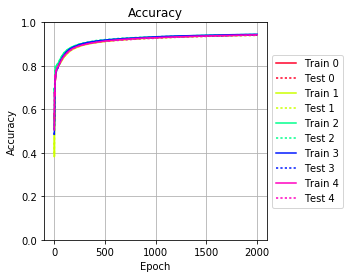

In [15]:
plot_acc(history)

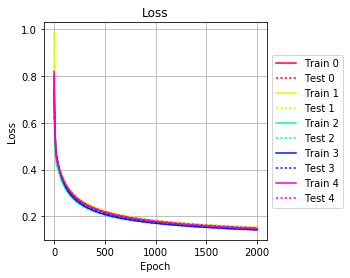

In [16]:
plot_loss(history)

Plotting the confusion matrix


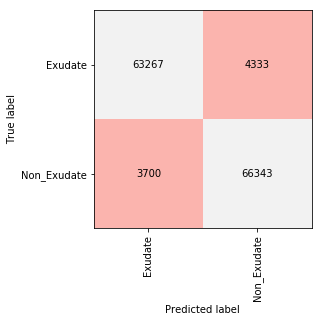

In [17]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


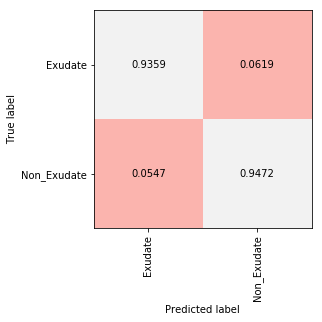

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=4)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat_norm,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Softmax-ConfusionMatrixNormalized_5fold_CV.pdf', format='pdf')
plt.show()